In [23]:
from data_prep_pipeline import DataPrepConfig, IntegratedMLflowPipeline
import polars as pl

from plotnine import ggplot, aes, geom_density, lims, facet_wrap

In [5]:
# data_config = DataPrepConfig(
#         target_classes=[110, 211, 221, 222, 231, 242, 244],
#         class_mapping_overrides={},
#         confidence_levels=["high"],
#         scl_values=[4, 5, 6],
#         months_range=(5,10),
#         duration_threshold_days=10000,
#         use_balanced_sampling=False,
#         max_samples_per_event=1,
#         random_seed=42
#     )

data_config = DataPrepConfig(
    target_classes=[110, 211, 231, 244, 242],
    # target_classes=[110, 211],
    # class_mapping_overrides={221: "Clear Cut", 222: "Clear Cut"},
    class_mapping_overrides={},
    confidence_levels=["high"],
    scl_values=[4, 5, 6],
    months_range=(5, 10),
    duration_threshold_days=90,
    use_balanced_sampling=False,
    random_seed=42,
    max_samples_per_event=4,
    # datasets=("Evoland",),
    remove_outliers=True,
    outlier_method="iqr",  # or "zscore", "modified_zscore"
    outlier_threshold=1.5,  # IQR multiplier or z-score threshold
)
pipeline = IntegratedMLflowPipeline()

In [7]:
train_df, test_df = pipeline._prepare_dataframes(data_config)
train_df = train_df.with_columns(
    ((pl.col.B08 - pl.col.B04) / (pl.col.B08 + pl.col.B04)).alias("NDVI"),
    baseline=pl.col.timestamps > pl.date(2022, 1, 1),
)

Removing outliers using iqr method per target class...
  Bark Beetle (with decline): Removed 98 outliers (9.77%) from 1,003 samples
  Wind: Removed 57 outliers (6.91%) from 825 samples
  Clear Cut: Removed 226 outliers (21.02%) from 1,075 samples
  Mature Forest: Removed 8,914 outliers (13.59%) from 65,598 samples
  Wildfire: Removed 56 outliers (11.45%) from 489 samples
Total outliers removed: 9,351 (13.55%) from 68,990 samples
Total remaining samples: 59,639


In [14]:
train_df["labels"].value_counts(sort=True)

labels,count
str,u32
"""Mature Forest""",2704
"""Clear Cut""",89
"""Bark Beetle (with decline)""",72
"""Wind""",60
"""Wildfire""",31


In [16]:
train_df.filter(labels="Clear Cut")

B02,B03,B04,B05,B06,B07,B08,B8A,B11,B12,SCL,labels,sample_id,timestamps,original_sample_id,interpreter,dataset,source,source_description,s2_tile,cluster_id,cluster_description,comment,confidence,cluster_id_int,labels_encoded,duration_days,NDVI,baseline
u16,u16,u16,u16,u16,u16,u16,u16,u16,u16,u16,str,u16,date,i64,str,str,str,str,str,str,str,str,str,u32,i64,i64,f64,bool
706,959,1246,1464,2423,2581,2458,2950,2701,1888,4,"""Clear Cut""",5,2021-07-02,5,"""pum""","""Evoland""","""EFFIS""","""Evoland Project, EFFIS Source …","""30SUF""","""6.0""","""Damage polygons""","""Rodung 2021""","""high""",5,1,75,0.327214,false
631,880,1446,1580,1896,2188,2236,2699,3146,2088,5,"""Clear Cut""",6,2021-08-06,6,"""pum""","""Evoland""","""EFFIS""","""Evoland Project, EFFIS Source …","""30SUF""","""7.0""","""Damage polygons""","""Rodung 2021""","""high""",6,1,80,0.214557,false
728,1005,1200,1587,1905,2170,2372,2560,3303,2521,5,"""Clear Cut""",7,2020-05-08,7,"""pum""","""Evoland""","""EFFIS""","""Evoland Project, EFFIS Source …","""30SUF""","""8.0""","""Damage polygons""","""Rodung 2021""","""high""",7,1,0,0.328108,false
848,1334,1604,1670,1583,1616,1592,1668,1842,1618,5,"""Clear Cut""",7,2020-07-07,7,"""pum""","""Evoland""","""EFFIS""","""Evoland Project, EFFIS Source …","""30SUF""","""8.0""","""Damage polygons""","""Rodung 2021""","""high""",7,1,60,20.501877,false
880,1376,1688,1760,1772,1826,1888,1924,2050,1713,5,"""Clear Cut""",8,2020-07-02,8,"""pum""","""Evoland""","""EFFIS""","""Evoland Project, EFFIS Source …","""30SUF""","""9.0""","""Damage polygons""","""Rodung 2021""","""high""",8,1,35,0.055928,false
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
753,929,1084,1727,1930,2072,2088,2242,2646,1980,5,"""Clear Cut""",597,2019-06-04,603,"""pum""","""Evoland""","""EFFIS""","""Evoland Project, EFFIS Source …","""33VVJ""","""160.0""","""Damage polygons""","""Kahlschlag 2019, vorher danebe…","""high""",158,1,35,0.31652,false
422,706,975,1538,2090,2337,2596,2697,2712,1496,4,"""Clear Cut""",599,2018-06-04,605,"""pum""","""Evoland""","""EFFIS""","""Evoland Project, EFFIS Source …","""33VVJ""","""161.0""","""Damage polygons""","""Kahlschlag 2018, 2018""","""high""",159,1,25,0.453934,false
434,705,1048,1555,2052,2304,2544,2654,2762,1533,4,"""Clear Cut""",599,2018-07-04,605,"""pum""","""Evoland""","""EFFIS""","""Evoland Project, EFFIS Source …","""33VVJ""","""161.0""","""Damage polygons""","""Kahlschlag 2018, 2018""","""high""",159,1,55,0.416481,false


In [15]:
only_two = train_df.filter(pl.col.labels.is_in(["Mature Forest", "Clear Cut"]))
only_two

B02,B03,B04,B05,B06,B07,B08,B8A,B11,B12,SCL,labels,sample_id,timestamps,original_sample_id,interpreter,dataset,source,source_description,s2_tile,cluster_id,cluster_description,comment,confidence,cluster_id_int,labels_encoded,duration_days,NDVI,baseline
u16,u16,u16,u16,u16,u16,u16,u16,u16,u16,u16,str,u16,date,i64,str,str,str,str,str,str,str,str,str,u32,i64,i64,f64,bool
231,557,571,1346,3666,4559,4736,5049,2622,1397,4,"""Mature Forest""",2,2019-05-29,2,"""pum""","""Evoland""","""EFFIS""","""Evoland Project, EFFIS Source …","""30SUF""","""2.0""","""Damage polygons""","""Durchforstung_2021, kein Chang…","""high""",2,2,140,0.784813,false
181,477,546,1152,3127,4016,3938,4523,2240,1189,4,"""Mature Forest""",2,2019-08-17,2,"""pum""","""Evoland""","""EFFIS""","""Evoland Project, EFFIS Source …","""30SUF""","""2.0""","""Damage polygons""","""Durchforstung_2021, kein Chang…","""high""",2,2,220,0.756467,false
101,398,414,954,3149,4222,4332,4637,2252,1212,4,"""Mature Forest""",2,2020-07-17,2,"""pum""","""Evoland""","""EFFIS""","""Evoland Project, EFFIS Source …","""30SUF""","""2.0""","""Damage polygons""","""Durchforstung_2021, kein Chang…","""high""",2,2,555,0.825537,false
192,466,460,1001,2927,3893,4002,4277,2016,1062,4,"""Mature Forest""",2,2020-08-21,2,"""pum""","""Evoland""","""EFFIS""","""Evoland Project, EFFIS Source …","""30SUF""","""2.0""","""Damage polygons""","""Durchforstung_2021, kein Chang…","""high""",2,2,590,0.793814,false
339,645,526,1065,3241,4235,4308,4679,1971,1007,4,"""Mature Forest""",3,2019-08-27,3,"""pum""","""Evoland""","""EFFIS""","""Evoland Project, EFFIS Source …","""30SUF""","""3.0""","""Damage polygons""","""Durchforstung 2021, unsicher""","""high""",3,2,230,0.782375,false
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
134,184,159,375,1151,1456,1408,1630,732,368,4,"""Mature Forest""",1004,2018-09-21,1266,"""pum""","""Evoland""","""Regional Forestry Departments""","""FNews Project, German Forestry…","""33UVS""","""419.0""","""Damage polygons""","""22""","""high""",529,2,665,0.797064,false
170,270,186,458,1269,1584,1616,1768,843,421,4,"""Mature Forest""",1004,2019-07-23,1266,"""pum""","""Evoland""","""Regional Forestry Departments""","""FNews Project, German Forestry…","""33UVS""","""419.0""","""Damage polygons""","""22""","""high""",529,2,970,0.793563,false
273,364,299,529,1198,1421,1382,1658,921,434,4,"""Mature Forest""",1004,2019-09-01,1266,"""pum""","""Evoland""","""Regional Forestry Departments""","""FNews Project, German Forestry…","""33UVS""","""419.0""","""Damage polygons""","""22""","""high""",529,2,1010,0.644259,false


In [16]:
train_df.group_by(["labels", "sample_id"]).agg(pl.col.timestamps.min())

labels,sample_id,timestamps
str,u16,date
"""Wildfire""",128,2021-10-05
"""Wildfire""",124,2021-10-05
"""Mature Forest""",192,2019-02-08
"""Mature Forest""",826,2015-07-04
"""Mature Forest""",3582,2016-05-06
…,…,…
"""Mature Forest""",640,2016-11-01
"""Mature Forest""",892,2015-07-30
"""Mature Forest""",180,2019-01-14


c:\Users\Jonas.Viehweger\Documents\Projects\2025\disturbance-agent-data\.venv\Lib\site-packages\plotnine\layer.py:293: PlotnineWarning: stat_density : Removed 363 rows containing non-finite values.


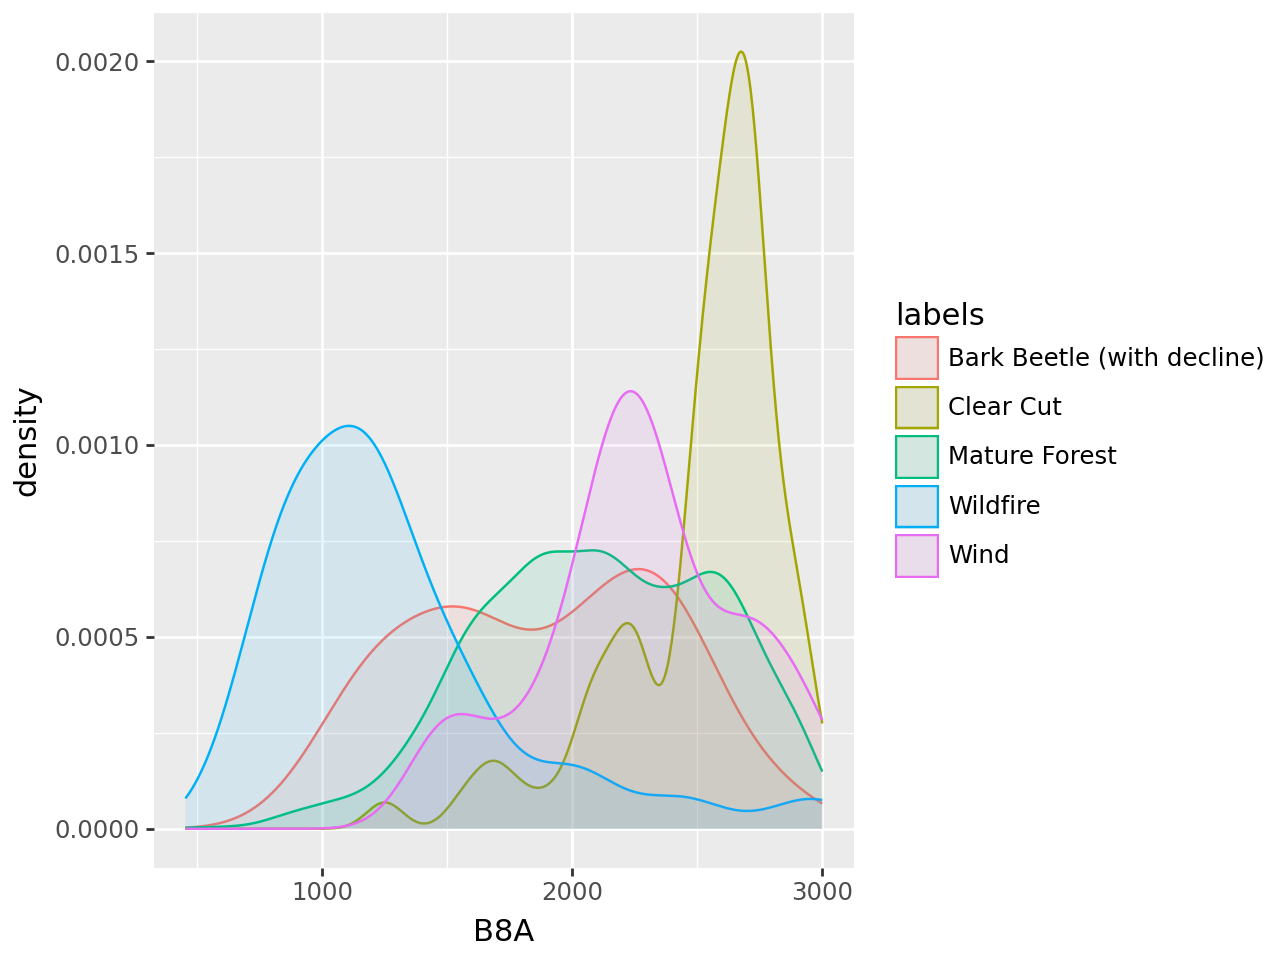

In [19]:
(
    ggplot(train_df, aes(x="B8A", color="labels", fill="labels"))
    + geom_density(alpha=0.1)
    + lims(x=(None, 3000))
)

In [21]:
start_date = (
    train_df.group_by(["labels", "sample_id"])
    .agg(pl.col.timestamps.min())
    .with_columns(pl.col.timestamps.dt.ordinal_day())
)

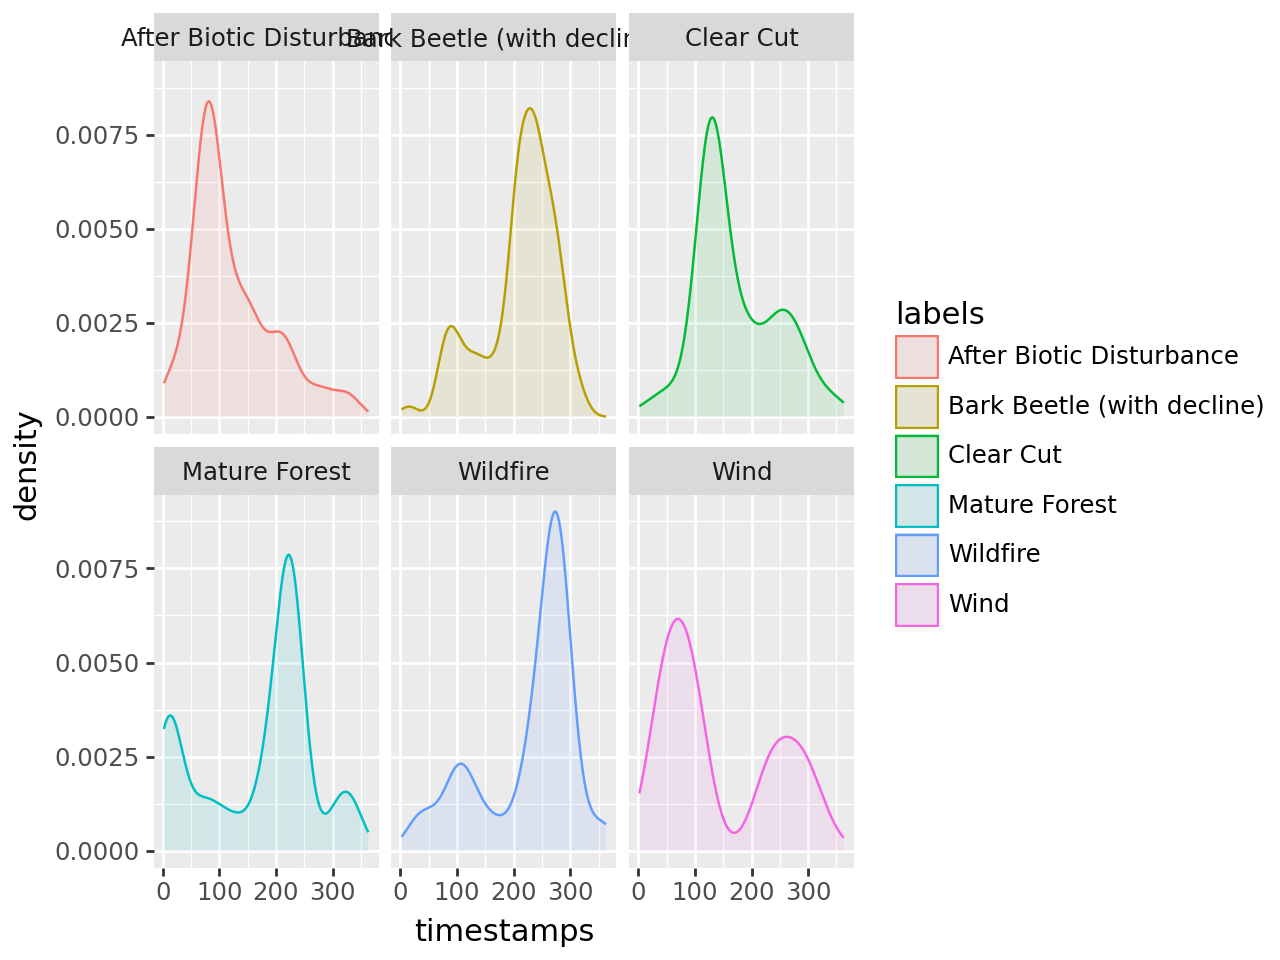

In [28]:
(
    ggplot(start_date, aes(x="timestamps", color="labels", fill="labels"))
    + geom_density(alpha=0.1)
    + facet_wrap("labels")
)

In [93]:
import mlflow.lightgbm

mlflow.set_tracking_uri("sqlite:///mlflow.db")

run_id = "2db7ba9264e84cbea18034c807f46a23"

model_uri = f"runs:/{run_id}/model"
loaded_model = mlflow.lightgbm.load_model(model_uri)

In [94]:
artifact = mlflow.artifacts.load_dict(f"runs:/{run_id}/dataset_metadata.json")

In [95]:
artifact["label_encoder_classes"]

['Bark Beetle (with decline)',
 'Clear Cut',
 'Mature Forest',
 'Wildfire',
 'Wind']

In [45]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(train_df["labels"])

LabelEncoder()

In [48]:
le.transform(
    ["Bark Beetle (with decline)", "Clear Cut", "Mature Forest", "Wildfire", "Wind"]
)

array([0, 1, 2, 3, 4])